In [1]:
from subset_select_non_uniform_entropic_FISTA_git import subset_select_non_uniform_FISTA as ss
from subset_select_ipot_non_uniform_git import subset_select_ipot as ss_ipot
import shutil
import os
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import random
import torch

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


:: Downsample with a voxel size 4.000.
:: Estimate normal with search radius 0.020.
:: Compute FPFH feature with search radius 0.050.
:: Downsample with a voxel size 4.000.
:: Estimate normal with search radius 0.020.
:: Compute FPFH feature with search radius 0.050.


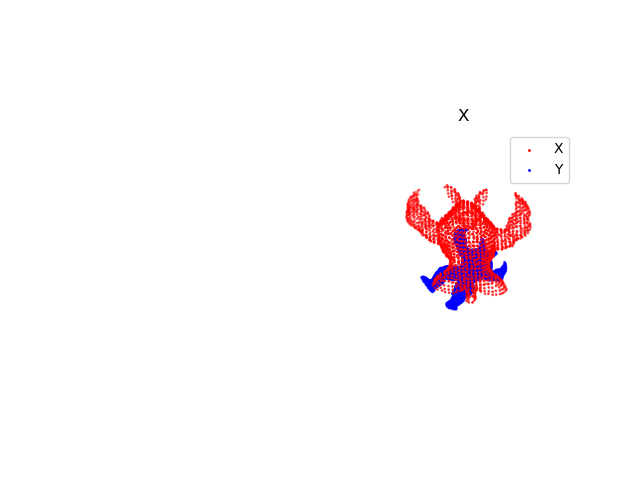

In [2]:
%matplotlib widget

voxel_size = 4

Armadillo_data = o3d.data.ArmadilloMesh()
Armadillo = o3d.io.read_triangle_mesh(Armadillo_data.path)
Armadillo.compute_vertex_normals()

pcd_mesh = o3d.io.read_point_cloud(Armadillo_data.path)
pcd = pcd_mesh.voxel_down_sample(voxel_size=voxel_size)

# o3d.visualization.draw_geometries([pcd])

# from open3d documentation


def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = 0.02
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = 0.05
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh


Y_pcd, Y_fpfh = preprocess_point_cloud(pcd, voxel_size=voxel_size)



Y_pc = np.asarray(Y_pcd.points)


X_pc0 = Y_pc[Y_pc[:, 1] > 0]  

alph = (np.pi/4)
Q = np.array([[np.cos(alph), -np.sin(alph), 0],
             [np.sin(alph),  np.cos(alph), 0], [0, 0, 1]])


X_pc0 = 2*(X_pc0)@Q.T + 20


X_pcd = o3d.geometry.PointCloud()
X_pcd.points = o3d.utility.Vector3dVector(X_pc0)
X_pcd, X_fpfh = preprocess_point_cloud(X_pcd, voxel_size=voxel_size)

X_pc = np.asarray(X_pcd.points)
fig = plt.figure(1)
ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.scatter(X_pc[:, 0], X_pc[:, 1], X_pc[:, 2], facecolor="r", label="X", s=1.0)
ax1.scatter(Y_pc[:, 0], Y_pc[:, 1], Y_pc[:, 2], facecolor="b", label="Y", s=1.0)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.set_title("X")
ax1.legend()
ax1.axis("off")
ax1.view_init(115, -45)

ax1.legend()
fig.savefig("armadillo.pdf", dpi=500, pad_inches = 0, bbox_inches=0, format='pdf')
fig.savefig("armadillo.png", dpi=500, pad_inches = 0, bbox_inches=0, format='png')
fig.savefig("armadillo.svg", dpi=500, pad_inches=0,
            bbox_inches=0, format='svg')


In [34]:
rng = np.random.default_rng(1)
sample_size = 256
batch_iter = 1

models_path = ""

max_outer_iter = 100
max_inner_iter = 20
max_epochs = 50
gamma = 0.01
wd = 2
d = 3
affine_iter = 1
# cs = [1,2,5,10,20]
cs = list(np.linspace(1,20,20))

Yd_cloud = Y_pc
Xd_cloud = X_pc
d = 3

Yd = np.zeros([sample_size, 3])

for c in cs:
    costs = []
    print("c=", c)
    Y_transfomed = Yd.copy()
    B = np.eye(3)
    t = np.zeros([3, 1])
    
    C = np.linalg.norm(Xd_cloud[:, None, :] - Yd_cloud, axis=2, ord=2)**2
    P = np.ones([X_pc.shape[0], Y_pc.shape[0]])
    cost_best = np.sum(P*C)
    
    for epoch in range(0, max_epochs):

        x_idx = list(np.random.choice(Xd_cloud.shape[0], sample_size))
        Xd = Xd_cloud[x_idx]

        y_idx = list(np.random.choice(Yd_cloud.shape[0], sample_size))
        Yd = Yd_cloud[y_idx]

        Y_transfomed = Yd@B.T + t.T

        for k in range(batch_iter):

            mu = np.ones([Xd.shape[0], 1])/Xd.shape[0]
            nu = np.ones([Y_transfomed.shape[0], 1])/Y_transfomed.shape[0]

            _, P, _, _ = ss_ipot(Xd, Y_transfomed, mu, nu, c, gamma, max_outer_iter=max_outer_iter,
                                 max_inner_iter = max_inner_iter, return_map=True)

            for k in range(affine_iter):
                Np = np.sum(P)
                a = np.sum(P, axis=1, keepdims=1)
                b = np.sum(P.T, axis=1, keepdims=1)

                mu_x = Xd.T@a/Np
                mu_y = Yd.T@b/Np
                
                D = np.diag(np.squeeze(b))

                Xhat = Xd - mu_x.T
                Yhat = Yd - mu_y.T
                B = (Xhat.T @ (P@Yhat)) @ np.linalg.pinv(Yhat.T @ (D@Yhat))
                t = mu_x - B@mu_y

            Y_transfomed = Yd@B.T + t.T

            ##################################################################################################################

            C = np.linalg.norm(Xd[:, None, :] - Y_transfomed, axis=2, ord=2)**2
            cost = np.sum(P*C)
            path = models_path + "armadillo_"+"c={cs}".format(cs=c)+".pth"
            
            if cost < cost_best:
                cost_best = cost
                torch.save({
                'epoch': epoch,
                'B': B,'t': t}, path)

        print(f'Epoch {epoch} Loss {cost.item():.4f}')
    Y_transfomed = Yd@B.T + t.T
   

c= 1.0
Epoch 0 Loss 1505.7504
Epoch 1 Loss 1137.5984
Epoch 2 Loss 1040.9820
Epoch 3 Loss 767.5680
Epoch 4 Loss 701.3953
Epoch 5 Loss 754.1017
Epoch 6 Loss 663.6430
Epoch 7 Loss 598.4087
Epoch 8 Loss 487.1274
Epoch 9 Loss 585.4439
Epoch 10 Loss 635.9874
Epoch 11 Loss 562.9846
Epoch 12 Loss 524.6037
Epoch 13 Loss 554.4820
Epoch 14 Loss 685.9803
Epoch 15 Loss 544.1969
Epoch 16 Loss 451.5548
Epoch 17 Loss 515.0075
Epoch 18 Loss 512.2375
Epoch 19 Loss 541.3642
Epoch 20 Loss 466.7765
Epoch 21 Loss 581.7009
Epoch 22 Loss 462.3345
Epoch 23 Loss 575.0112
Epoch 24 Loss 703.8367
Epoch 25 Loss 580.9638
Epoch 26 Loss 618.6686
Epoch 27 Loss 539.1078
Epoch 28 Loss 532.2933
Epoch 29 Loss 548.1657
Epoch 30 Loss 546.0098
Epoch 31 Loss 526.3761
Epoch 32 Loss 423.8292
Epoch 33 Loss 703.4060
Epoch 34 Loss 625.7824
Epoch 35 Loss 576.7343
Epoch 36 Loss 495.7861
Epoch 37 Loss 564.5233
Epoch 38 Loss 519.0498
Epoch 39 Loss 590.2175
Epoch 40 Loss 530.6415
Epoch 41 Loss 626.0513
Epoch 42 Loss 624.8848
Epoch 43 Lo

In [ ]:
import matplotlib.font_manager as font_manager

models_path = ""

fig = plt.figure(figsize=(10,3))
cs = [1, 2, 5, 10,20]
font = font_manager.FontProperties(style='normal', size=8)

ax = fig.add_subplot(1, len(cs)+1, 1, projection='3d')
ax.scatter(X_pc[:, 0], X_pc[:, 1], X_pc[:, 2], facecolor="r", label="X", s=0.2)
ax.scatter(Y_pc[:, 0], Y_pc[:, 1], Y_pc[:, 2], facecolor="b",  label="Y", s=0.2)
ax.axis("off")

ax.view_init(115, -45)
ax.grid(visible=0)
ax.legend(loc=[0, 0], ncol=2, prop=font)

X_hatf = X_pc
Yd_cloud = Y_pc

for i in range(len(cs)):
    print("c=",cs[i])
    path = models_path + "armadillo_"+"c={cs:1d}".format(cs=cs[i])+".pth"
    model_dict = torch.load(path)
    B = model_dict["B"]
    t = model_dict["t"]
    ax = fig.add_subplot(1, len(cs)+1, i+2, projection='3d')
    Y_hatf = Yd_cloud@B.T + t.T
    ax.scatter(Y_hatf[:, 0], Y_hatf[:, 1], Y_hatf[:, 2],s=0.2, facecolor="b", label="Y")
    ax.scatter(X_hatf[:, 0], X_hatf[:, 1], X_hatf[:, 2], s=0.2, facecolor="r", label="X")
    ax.axis("off")
    ax.view_init(115,-45)
    ax.grid(visible=0)
    ax.set_title("c="+str(cs[i]), pad = -2)

plt.subplots_adjust(wspace=-0.20, hspace=-0)

In [ ]:
import matplotlib.font_manager as font_manager

models_path = ""

fig = plt.figure(figsize=(10,3))
cs = [1, 2, 5, 10,20]
font = font_manager.FontProperties(style='normal', size=8)

ax = fig.add_subplot(1, len(cs)+1, 1, projection='3d')
ax.scatter(X_pc[:, 0], X_pc[:, 1], X_pc[:, 2], facecolor="r", label="X", s=0.2)
ax.scatter(Y_pc[:, 0], Y_pc[:, 1], Y_pc[:, 2], facecolor="b",  label="Y", s=0.2)
ax.axis("off")
ax.view_init(115,-45)
ax.grid(visible=0)
ax.legend(loc=[0, 0], ncol=2, prop=font)

X_hatf = X_pc
Yd_cloud = Y_pc

for i in range(len(cs)):
    print("c=",cs[i])
    path = models_path + "armadillo_"+"c={cs:1d}".format(cs=cs[i])+".pth"
    model_dict = torch.load(path)
    B = model_dict["B"]
    t = model_dict["t"]
    ax = fig.add_subplot(1, len(cs)+1, i+2, projection='3d')
    Y_hatf = Yd_cloud@B.T + t.T
    ax.scatter(Y_hatf[:, 0], Y_hatf[:, 1], Y_hatf[:, 2],s=0.2, facecolor="b", label="Y")
    ax.scatter(X_hatf[:, 0], X_hatf[:, 1], X_hatf[:, 2], s=0.2, facecolor="r", label="X")
    ax.axis("off")
    ax.view_init(115, -45)
    ax.grid(visible=0)
    ax.set_title("c="+str(cs[i]), pad = -2)

plt.subplots_adjust(wspace=-0.20, hspace=-0)
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc=[0.5, 0], bbox_to_anchor=(0.65,1.05))

fig.savefig("armadillo_aligned.pdf", dpi=500, pad_inches=0, bbox_inches='tight', format='pdf')
fig.savefig("armadillo_aligned.png", dpi=500, pad_inches=0, bbox_inches='tight', format='png')
fig.savefig("armadillo_aligned.svg", dpi=500, pad_inches=0,
            bbox_inches='tight', format='svg')
